In [1]:
from kagglehub import dataset_download
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

C:\Users\nnn866470\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = dataset_download("yufengdev/bbc-fulltext-and-category")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\nnn866470\.cache\kagglehub\datasets\yufengdev\bbc-fulltext-and-category\versions\2


In [3]:
df = pd.read_csv(path+ "/bbc-text.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
df.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,europe backs digital tv lifestyle how people r...
freq,511,2


In [6]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [7]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

Check for class weightage

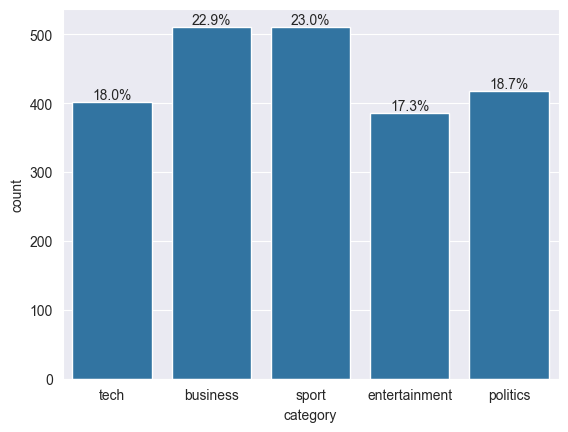

In [8]:
ax=sns.countplot(x=df['category'], data = df)
total = len(df['category'])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

One hot encoding the category column

In [9]:
ohe = OneHotEncoder()
X_category = ohe.fit_transform(df[["category"]])

Apply TF IDF  to  the dataset to convert the text data into numerical

In [10]:
vectorizer = TfidfVectorizer(
    lowercase=True,        # make everything lowercase (default=True)
    stop_words='english',  # remove English stopwords (or give your own list)
    max_df=0.8,            # ignore words that appear in >80% of docs
    min_df=3,              # ignore words that appear in <3 docs
    ngram_range=(1,2)      # use unigrams and bigrams ("machine", "machine learning")
)

In [11]:
X_text = vectorizer.fit_transform(df['text'])